# Part 1 : Question 1

Loaded train_data with 100 clients.
Loaded test_data with shape: <class 'list'>, 3621 test samples.

Number of clients in training set: 100

=== Global Class Distribution ===
Total number of training samples: 31825
Counts per class (0–61):
[ 999 1094  904 1015  897  819  907  997  930  955  412  193  711  322
  504  629   67  191  748  190   65  322  562  577 1837  555   75  410
 1606  705  891  257  243   84  244   77  600  253   77  625 1680   78
  165  519   94   56   79 1584   70  761   78   62  139 1031   77 1338
   68   82   81   91   66   77]

Proportions per class (0–61):
[0.0314 0.0344 0.0284 0.0319 0.0282 0.0257 0.0285 0.0313 0.0292 0.03
 0.0129 0.0061 0.0223 0.0101 0.0158 0.0198 0.0021 0.006  0.0235 0.006
 0.002  0.0101 0.0177 0.0181 0.0577 0.0174 0.0024 0.0129 0.0505 0.0222
 0.028  0.0081 0.0076 0.0026 0.0077 0.0024 0.0189 0.0079 0.0024 0.0196
 0.0528 0.0025 0.0052 0.0163 0.003  0.0018 0.0025 0.0498 0.0022 0.0239
 0.0025 0.0019 0.0044 0.0324 0.0024 0.042  0.0021 0.0026 0.00

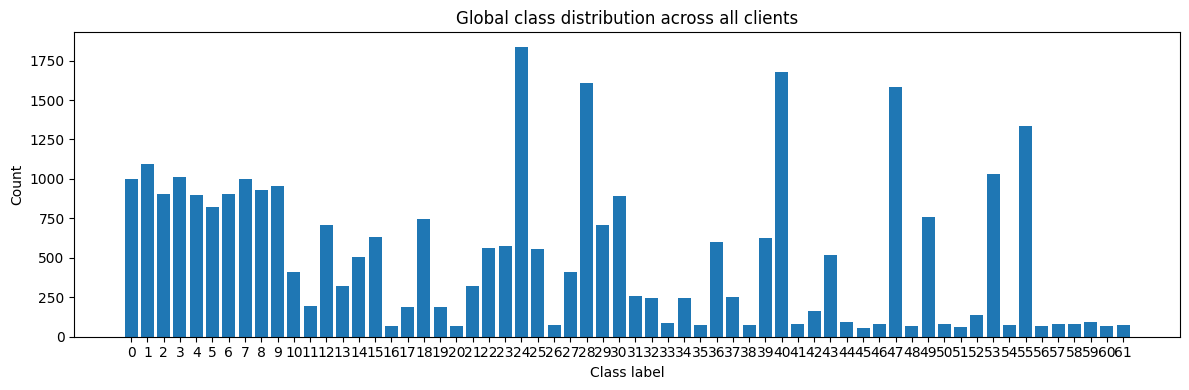

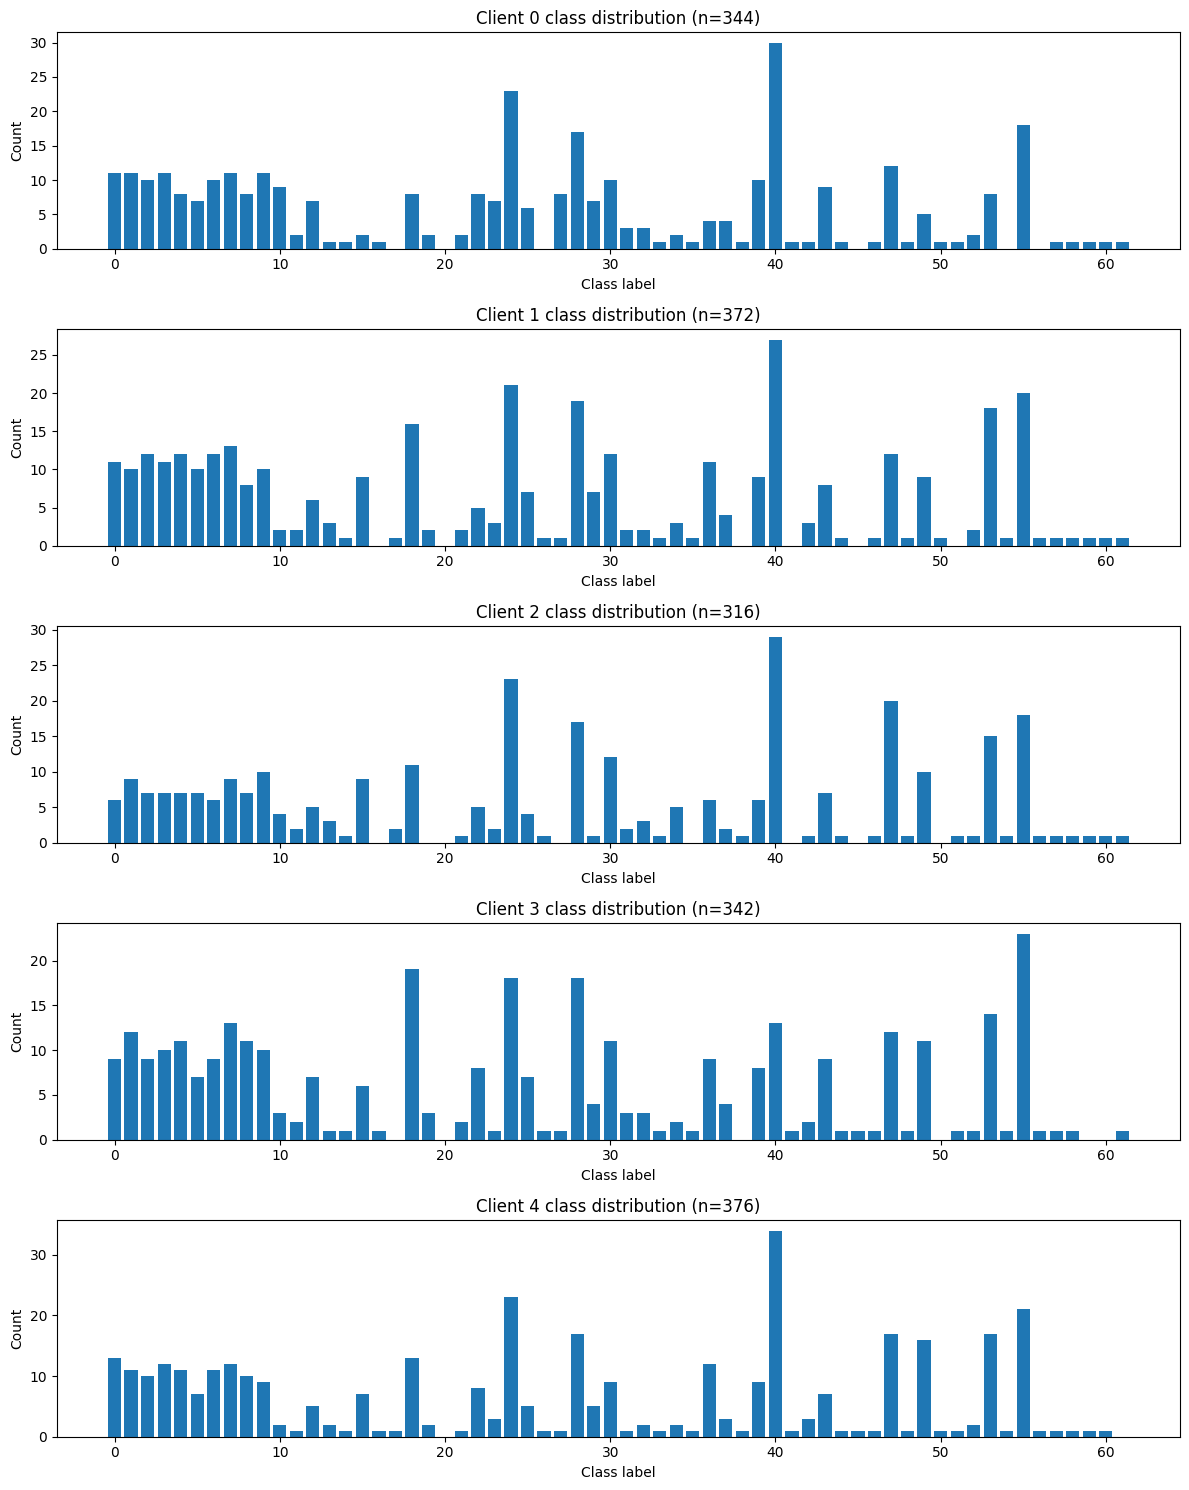

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Config
# -------------------------------
NUM_CLASSES = 62          # Labels are 0–61
DATA_DIR = "HW3-data/Assignment3-data"     # folder containing the npy files


TRAIN_PATH = os.path.join(DATA_DIR, "train_data.npy")
TEST_PATH  = os.path.join(DATA_DIR, "test_data.npy")



# -------------------------------
# Load data
# -------------------------------
def load_data(train_path=TRAIN_PATH, test_path=TEST_PATH):
    """
    Load federated train and global test data.

    train_data[i]['images'], train_data[i]['labels'] give the local data
    for client i, as described in the README.
    """
    train_data = np.load(train_path, allow_pickle=True)
    test_data = np.load(test_path, allow_pickle=True)
    print(f"Loaded train_data with {len(train_data)} clients.")
    print(f"Loaded test_data with shape: {test_data[0]['images'].__class__}, "
          f"{len(test_data[0]['images'])} test samples.")
    return train_data, test_data


# -------------------------------
# Distribution helpers
# -------------------------------
def get_global_distribution(train_data, num_classes=NUM_CLASSES):
    """
    Compute the class distribution aggregated across ALL clients.
    Returns (counts, probabilities).
    """
    all_labels = []
    for client in train_data:
        all_labels.extend(client["labels"])
    all_labels = np.array(all_labels, dtype=int)

    counts = np.bincount(all_labels, minlength=num_classes)
    probs = counts / counts.sum()
    return counts, probs


def get_client_distribution(train_data, client_id, num_classes=NUM_CLASSES):
    """
    Compute the class distribution for a single client.
    Returns (counts, probabilities).
    """
    labels = np.array(train_data[client_id]["labels"], dtype=int)
    counts = np.bincount(labels, minlength=num_classes)
    probs = counts / counts.sum()
    return counts, probs


# -------------------------------
# Plotting functions
# -------------------------------
def plot_global_distribution(global_counts):
    """
    Bar plot of global class counts.
    """
    classes = np.arange(len(global_counts))

    plt.figure(figsize=(12, 4))
    plt.bar(classes, global_counts)
    plt.xlabel("Class label")
    plt.ylabel("Count")
    plt.title("Global class distribution across all clients")
    plt.xticks(classes)  # you can thin these out if it's too crowded
    plt.tight_layout()
    plt.show()


def plot_client_distributions(train_data, client_ids, num_classes=NUM_CLASSES):
    """
    Bar plots of per-client class distributions for the given list of client_ids.
    """
    num_clients = len(client_ids)
    classes = np.arange(num_classes)

    plt.figure(figsize=(12, 3 * num_clients))

    for idx, cid in enumerate(client_ids, start=1):
        labels = np.array(train_data[cid]["labels"], dtype=int)
        counts = np.bincount(labels, minlength=num_classes)

        ax = plt.subplot(num_clients, 1, idx)
        ax.bar(classes, counts)
        ax.set_title(f"Client {cid} class distribution (n={labels.size})")
        ax.set_xlabel("Class label")
        ax.set_ylabel("Count")

    plt.tight_layout()
    plt.show()


# -------------------------------
# Main: runs Part 1, Q1 analysis
# -------------------------------
if __name__ == "__main__":
    # 1) Load data
    train_data, test_data = load_data()

    num_clients = len(train_data)
    print(f"\nNumber of clients in training set: {num_clients}")

    # 2) Global distribution across all clients
    global_counts, global_probs = get_global_distribution(train_data, NUM_CLASSES)

    print("\n=== Global Class Distribution ===")
    print("Total number of training samples:", global_counts.sum())
    print("Counts per class (0–61):")
    print(global_counts)
    print("\nProportions per class (0–61):")
    print(np.round(global_probs, 4))

    # 3) Example individual users (you can pick any 5 IDs you want)
    example_clients = [0, 1, 2, 3, 4]  # change these if you prefer different clients

    for cid in example_clients:
        counts, probs = get_client_distribution(train_data, cid, NUM_CLASSES)
        print(f"\n=== Client {cid} ===")
        print(f"Number of local samples: {counts.sum()}")

        # Show the top-5 most common classes for this client
        top5_idx = counts.argsort()[::-1][:5]
        print("Top 5 classes by count:")
        for k in top5_idx:
            if counts[k] > 0:
                print(f"  Class {k}: {counts[k]} samples ({probs[k]:.3%})")

    # 4) Plots for your report
    plot_global_distribution(global_counts)
    plot_client_distributions(train_data, example_clients, NUM_CLASSES)


# Part 1 : Question 2

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import ray

# =============================
# Config
# =============================
NUM_CLASSES = 62
DATA_DIR = "HW3-data/Assignment3-data"
TRAIN_PATH = os.path.join(DATA_DIR, "train_data.npy")
TEST_PATH = os.path.join(DATA_DIR, "test_data.npy")

BATCH_SIZE = 32
LOCAL_EPOCHS = 2          # you can tune this
LR = 0.01
NUM_ROUNDS = 50           # number of FedAvg communication rounds
CLIENTS_PER_ROUND = 4     # required for Ray part

VAL_SPLIT = 0.2           # 80/20 train/val per client
RANDOM_SEED = 42

# =============================
# Seeding for reproducibility
# =============================
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


# =============================
# Data loading helpers
# =============================
def load_federated_data(train_path=TRAIN_PATH, test_path=TEST_PATH):
    train_data = np.load(train_path, allow_pickle=True)
    test_data = np.load(test_path, allow_pickle=True)

    print(f"Loaded train_data with {len(train_data)} clients.")
    print(f"Loaded test_data with {len(test_data[0]['images'])} test samples.")
    return train_data, test_data


def split_client_data(images, labels, val_split=VAL_SPLIT):
    """
    Split a single client's data into train/val sets (80/20 by default).
    """
    num_samples = len(images)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    split_point = int(num_samples * (1.0 - val_split))
    train_idx = indices[:split_point]
    val_idx = indices[split_point:]

    train_images = images[train_idx]
    train_labels = labels[train_idx]
    val_images = images[val_idx]
    val_labels = labels[val_idx]

    return train_images, train_labels, val_images, val_labels


class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.astype(np.float32) / 255.0  # normalize to [0,1]
        self.labels = labels.astype(np.int64)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = self.images[idx]  # shape (28, 28)
        x = torch.from_numpy(x).view(-1)  # flatten to 784
        y = torch.tensor(self.labels[idx])
        return x, y


# =============================
# Model definition
# =============================
class SimpleNet(nn.Module):
    """
    2-layer fully connected network:
    784 -> 128 -> 62 with ReLU
    """
    def __init__(self, input_dim=28*28, hidden_dim=128, num_classes=NUM_CLASSES):
        super(SimpleNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes),
        )

    def forward(self, x):
        return self.net(x)


# =============================
# Evaluation helper
# =============================
def evaluate_model(model, dataloader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)

            total_loss += loss.item() * y.size(0)
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


# =============================
# Ray Actor for a single client
# =============================
@ray.remote(num_cpus=1, num_gpus=0)  # set num_gpus=1 if you want one GPU per actor
class ClientTrainer:
    def __init__(self, train_images, train_labels, val_images, val_labels,
                 batch_size=BATCH_SIZE, local_epochs=LOCAL_EPOCHS, lr=LR):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.train_dataset = ImageDataset(train_images, train_labels)
        self.val_dataset = ImageDataset(val_images, val_labels)

        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=batch_size, shuffle=False)

        self.local_epochs = local_epochs
        self.lr = lr

        # model will be recreated each round from global weights
        self.input_dim = 28 * 28
        self.hidden_dim = 128
        self.num_classes = NUM_CLASSES

        self.num_train_samples = len(self.train_dataset)

    def train_one_round(self, global_state_dict):
        """
        Receive global weights, train locally for a few epochs,
        and return updated weights + train/val metrics.
        """
        model = SimpleNet(self.input_dim, self.hidden_dim, self.num_classes).to(self.device)
        model.load_state_dict(global_state_dict)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=self.lr)

        # ---- Local training ----
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for epoch in range(self.local_epochs):
            for x, y in self.train_loader:
                x = x.to(self.device)
                y = y.to(self.device)

                optimizer.zero_grad()
                outputs = model(x)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item() * y.size(0)
                _, preds = torch.max(outputs, 1)
                total_train_correct += (preds == y).sum().item()
                total_train_samples += y.size(0)

        avg_train_loss = total_train_loss / total_train_samples
        train_acc = total_train_correct / total_train_samples

        # ---- Validation ----
        val_loss, val_acc = evaluate_model(model, self.val_loader, self.device)

        # Move weights back to CPU for Ray to transport
        updated_state_dict = {k: v.cpu() for k, v in model.state_dict().items()}

        metrics = {
            "train_loss": avg_train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "num_train_samples": total_train_samples,
        }

        return updated_state_dict, metrics


# =============================
# FedAvg aggregation
# =============================
def fedavg_aggregate(client_states, client_sizes):
    """
    Weighted average of client model parameters.
    client_states: list of state_dicts (one per client)
    client_sizes:  list of number of training samples (same order)
    """
    total_samples = sum(client_sizes)
    global_state = {}

    # initialize with zeros
    for key in client_states[0].keys():
        global_state[key] = torch.zeros_like(client_states[0][key])

    for state, n_k in zip(client_states, client_sizes):
        weight = n_k / total_samples
        for key in global_state.keys():
            global_state[key] += state[key] * weight

    return global_state


# =============================
# Main FedAvg with Ray
# =============================
def main():
    # --- Init Ray ---
    ray.init(ignore_reinit_error=True)

    # --- Load federated data ---
    train_data, test_data = load_federated_data()
    num_clients = len(train_data)
    print(f"Number of clients: {num_clients}")

    # --- Pre-split per-client data into train/val ---
    client_splits = []
    for client_id in range(num_clients):
        images = train_data[client_id]["images"]
        labels = train_data[client_id]["labels"]
        tr_img, tr_lbl, val_img, val_lbl = split_client_data(images, labels, VAL_SPLIT)
        client_splits.append((tr_img, tr_lbl, val_img, val_lbl))

    # --- Prepare global test loader ---
    test_images = test_data[0]["images"].astype(np.float32) / 255.0
    test_labels = test_data[0]["labels"].astype(np.int64)

    test_dataset = ImageDataset(test_images, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # --- Initialize global model ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model = SimpleNet().to(device)
    global_state = {k: v.cpu() for k, v in global_model.state_dict().items()}

    # --- Tracking metrics across rounds ---
    round_train_losses = []
    round_val_losses = []
    round_train_accs = []
    round_val_accs = []

    for rnd in range(1, NUM_ROUNDS + 1):
        print(f"\n=== Communication Round {rnd}/{NUM_ROUNDS} ===")

        # Sample clients for this round
        selected_clients = random.sample(range(num_clients), CLIENTS_PER_ROUND)
        print(f"Selected clients: {selected_clients}")

        # Create Ray actors for selected clients
        actors = []
        for cid in selected_clients:
            tr_img, tr_lbl, val_img, val_lbl = client_splits[cid]
            actor = ClientTrainer.remote(tr_img, tr_lbl, val_img, val_lbl)
            actors.append(actor)

        # Broadcast current global model weights to clients and start training
        global_state_copy = {k: v.clone() for k, v in global_state.items()}  # safety copy

        futures = [
            actor.train_one_round.remote(global_state_copy)
            for actor in actors
        ]

        results = ray.get(futures)

        client_states = []
        client_sizes = []
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []

        for (updated_state, metrics), cid in zip(results, selected_clients):
            client_states.append(updated_state)
            client_sizes.append(metrics["num_train_samples"])
            train_losses.append(metrics["train_loss"])
            train_accs.append(metrics["train_acc"])
            val_losses.append(metrics["val_loss"])
            val_accs.append(metrics["val_acc"])

            print(
                f"Client {cid}: "
                f"train_loss={metrics['train_loss']:.4f}, "
                f"train_acc={metrics['train_acc']:.4f}, "
                f"val_loss={metrics['val_loss']:.4f}, "
                f"val_acc={metrics['val_acc']:.4f}"
            )

        # FedAvg aggregation step
        global_state = fedavg_aggregate(client_states, client_sizes)

        # Log aggregated (simple mean of metrics across selected clients)
        avg_train_loss = float(np.mean(train_losses))
        avg_val_loss = float(np.mean(val_losses))
        avg_train_acc = float(np.mean(train_accs))
        avg_val_acc = float(np.mean(val_accs))

        round_train_losses.append(avg_train_loss)
        round_val_losses.append(avg_val_loss)
        round_train_accs.append(avg_train_acc)
        round_val_accs.append(avg_val_acc)

        print(
            f"[Round {rnd}] Avg Train Loss: {avg_train_loss:.4f}, "
            f"Avg Val Loss: {avg_val_loss:.4f}, "
            f"Avg Train Acc: {avg_train_acc:.4f}, "
            f"Avg Val Acc: {avg_val_acc:.4f}"
        )

    # --- Load final global weights into model and evaluate on test set ---
    global_model.load_state_dict(global_state)
    global_model.to(device)

    test_loss, test_acc = evaluate_model(global_model, test_loader, device)
    print(f"\n=== Final Test Performance ===")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # --- Plot metrics across rounds ---
    rounds = np.arange(1, NUM_ROUNDS + 1)

    plt.figure(figsize=(10, 4))
    plt.plot(rounds, round_train_losses, label="Train Loss")
    plt.plot(rounds, round_val_losses, label="Val Loss")
    plt.xlabel("Communication Round")
    plt.ylabel("Loss")
    plt.title("Train/Validation Loss vs Rounds (Ray FedAvg)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(rounds, round_train_accs, label="Train Accuracy")
    plt.plot(rounds, round_val_accs, label="Val Accuracy")
    plt.xlabel("Communication Round")
    plt.ylabel("Accuracy")
    plt.title("Train/Validation Accuracy vs Rounds (Ray FedAvg)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Shutdown Ray
    ray.shutdown()


if __name__ == "__main__":
    main()


# Part 2


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# =============================
# Config
# =============================
NUM_CLASSES = 62
DATA_DIR = "HW3-data/Assignment3-data"
TRAIN_PATH = os.path.join(DATA_DIR, "train_data.npy")
TEST_PATH = os.path.join(DATA_DIR, "test_data.npy")

BATCH_SIZE = 32
LOCAL_EPOCHS = 2         # can tune
LR = 0.01
NUM_ROUNDS = 50          # communication rounds
CLIENT_FRAC = 0.1        # C = 10% of clients per round

VAL_SPLIT = 0.2          # 80/20 train/val per client
RANDOM_SEED = 42

# Noise scales to sweep for Part 2
NOISE_SCALES = [0.0, 0.01, 0.1, 0.5, 1.0]


# =============================
# Reproducibility
# =============================
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


# =============================
# Data loading helpers
# =============================
def load_federated_data(train_path=TRAIN_PATH, test_path=TEST_PATH):
    train_data = np.load(train_path, allow_pickle=True)
    test_data = np.load(test_path, allow_pickle=True)

    print(f"Loaded train_data with {len(train_data)} clients.")
    print(f"Loaded test_data with {len(test_data[0]['images'])} test samples.")
    return train_data, test_data


def split_client_data(images, labels, val_split=VAL_SPLIT):
    """Split a single client's data into train/val sets (80/20 by default)."""
    num_samples = len(images)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    split_point = int(num_samples * (1.0 - val_split))
    train_idx = indices[:split_point]
    val_idx = indices[split_point:]

    train_images = images[train_idx]
    train_labels = labels[train_idx]
    val_images = images[val_idx]
    val_labels = labels[val_idx]

    return train_images, train_labels, val_images, val_labels


# =============================
# Datasets
# =============================
class NoisyImageDataset(Dataset):
    """
    Dataset that normalizes images to [0,1] and (optionally) adds Laplace noise
    with scale noise_scale *at each access* (differential privacy).
    """
    def __init__(self, images, labels, noise_scale=0.0, add_noise=True):
        self.images = images.astype(np.float32) / 255.0
        self.labels = labels.astype(np.int64)
        self.noise_scale = noise_scale
        self.add_noise = add_noise

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = self.images[idx].copy()  # (28, 28)
        if self.add_noise and self.noise_scale > 0.0:
            noise = np.random.laplace(loc=0.0, scale=self.noise_scale, size=x.shape).astype(
                np.float32
            )
            x = x + noise
            # (optional) Clip to [0,1] for stability
            x = np.clip(x, 0.0, 1.0)

        x = torch.from_numpy(x).view(-1)  # flatten to 784
        y = torch.tensor(self.labels[idx])
        return x, y


# =============================
# Model
# =============================
class SimpleNet(nn.Module):
    """
    2-layer fully connected network:
    784 -> 128 -> 62 with ReLU
    """
    def __init__(self, input_dim=28 * 28, hidden_dim=128, num_classes=NUM_CLASSES):
        super(SimpleNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes),
        )

    def forward(self, x):
        return self.net(x)


# =============================
# Eval helper
# =============================
def evaluate_model(model, dataloader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)

            total_loss += loss.item() * y.size(0)
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


# =============================
# Local training
# =============================
def local_train(
    global_state_dict,
    train_loader,
    val_loader,
    device,
    local_epochs=LOCAL_EPOCHS,
    lr=LR,
):
    """
    One client's local training given global weights.
    Returns updated state_dict and metrics.
    """
    model = SimpleNet().to(device)
    model.load_state_dict(global_state_dict)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # ---- Local training ----
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    for epoch in range(local_epochs):
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * y.size(0)
            _, preds = torch.max(outputs, 1)
            total_train_correct += (preds == y).sum().item()
            total_train_samples += y.size(0)

    avg_train_loss = total_train_loss / total_train_samples
    train_acc = total_train_correct / total_train_samples

    # ---- Validation ----
    val_loss, val_acc = evaluate_model(model, val_loader, device)

    metrics = {
        "train_loss": avg_train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "num_train_samples": total_train_samples,
    }

    # move back to CPU
    updated_state_dict = {k: v.cpu() for k, v in model.state_dict().items()}
    return updated_state_dict, metrics


# =============================
# FedAvg aggregation
# =============================
def fedavg_aggregate(client_states, client_sizes):
    """
    Weighted average of client model parameters.
    client_states: list of state_dicts
    client_sizes:  list of number of local training samples
    """
    total_samples = sum(client_sizes)
    global_state = {}

    # initialize with zeros
    for key in client_states[0].keys():
        global_state[key] = torch.zeros_like(client_states[0][key])

    for state, n_k in zip(client_states, client_sizes):
        weight = n_k / total_samples
        for key in global_state.keys():
            global_state[key] += state[key] * weight

    return global_state


# =============================
# Main DP FedAvg experiment
# =============================
def run_dp_fedavg_for_noise_scale(
    noise_scale,
    train_data,
    test_loader,
    num_rounds=NUM_ROUNDS,
    client_frac=CLIENT_FRAC,
):
    """
    Run FedAvg with Laplace noise of scale `noise_scale` on training images.
    Returns per-round metrics and final test metrics.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_clients = len(train_data)
    num_sampled = max(1, int(client_frac * num_clients))

    # Pre-split client data once (no noise added here; noise is applied in Dataset)
    client_splits = []
    for client_id in range(num_clients):
        images = train_data[client_id]["images"]
        labels = train_data[client_id]["labels"]
        tr_img, tr_lbl, val_img, val_lbl = split_client_data(images, labels, VAL_SPLIT)
        client_splits.append((tr_img, tr_lbl, val_img, val_lbl))

    # Initialize global model
    global_model = SimpleNet().to(device)
    global_state = {k: v.cpu() for k, v in global_model.state_dict().items()}

    # Tracking metrics
    round_train_losses = []
    round_val_losses = []
    round_train_accs = []
    round_val_accs = []

    for rnd in range(1, num_rounds + 1):
        print(f"\n[Noise b={noise_scale}] Round {rnd}/{num_rounds}")

        # Sample subset of clients
        selected_clients = random.sample(range(num_clients), num_sampled)

        client_states = []
        client_sizes = []
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []

        for cid in selected_clients:
            tr_img, tr_lbl, val_img, val_lbl = client_splits[cid]

            # Training dataset uses Laplace noise
            train_dataset = NoisyImageDataset(
                tr_img, tr_lbl, noise_scale=noise_scale, add_noise=True
            )
            val_dataset = NoisyImageDataset(
                val_img, val_lbl, noise_scale=0.0, add_noise=False
            )  # *no noise* on validation

            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

            updated_state, metrics = local_train(
                global_state, train_loader, val_loader, device
            )

            client_states.append(updated_state)
            client_sizes.append(metrics["num_train_samples"])
            train_losses.append(metrics["train_loss"])
            train_accs.append(metrics["train_acc"])
            val_losses.append(metrics["val_loss"])
            val_accs.append(metrics["val_acc"])

        # FedAvg aggregation
        global_state = fedavg_aggregate(client_states, client_sizes)

        # Log aggregated metrics (simple mean over selected clients)
        avg_train_loss = float(np.mean(train_losses))
        avg_val_loss = float(np.mean(val_losses))
        avg_train_acc = float(np.mean(train_accs))
        avg_val_acc = float(np.mean(val_accs))

        round_train_losses.append(avg_train_loss)
        round_val_losses.append(avg_val_loss)
        round_train_accs.append(avg_train_acc)
        round_val_accs.append(avg_val_acc)

        print(
            f"[Noise b={noise_scale}] "
            f"TrainLoss={avg_train_loss:.4f}, ValLoss={avg_val_loss:.4f}, "
            f"TrainAcc={avg_train_acc:.4f}, ValAcc={avg_val_acc:.4f}"
        )

    # Final test evaluation on *clean* test data
    global_model.load_state_dict(global_state)
    global_model.to(device)
    test_loss, test_acc = evaluate_model(global_model, test_loader, device)

    return {
        "train_losses": round_train_losses,
        "val_losses": round_val_losses,
        "train_accs": round_train_accs,
        "val_accs": round_val_accs,
        "test_loss": test_loss,
        "test_acc": test_acc,
    }


def main():
    # Load data
    train_data, test_data = load_federated_data()

    # Build global (clean) test loader
    test_images = test_data[0]["images"].astype(np.float32) / 255.0
    test_labels = test_data[0]["labels"].astype(np.int64)
    test_dataset = NoisyImageDataset(test_images, test_labels, noise_scale=0.0, add_noise=False)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    all_results = {}
    final_train_accs = []
    final_test_accs = []

    # Run experiment for each noise scale
    for b in NOISE_SCALES:
        print(f"\n==============================")
        print(f"Running FedAvg with Laplace noise scale b = {b}")
        print(f"==============================")

        results = run_dp_fedavg_for_noise_scale(
            noise_scale=b, train_data=train_data, test_loader=test_loader
        )
        all_results[b] = results

        final_train_accs.append(results["train_accs"][-1])
        final_test_accs.append(results["test_acc"])

        # Plot train/val accuracy vs rounds for this b
        rounds = np.arange(1, NUM_ROUNDS + 1)
        plt.figure(figsize=(10, 4))
        plt.plot(rounds, results["train_accs"], label="Train Accuracy")
        plt.plot(rounds, results["val_accs"], label="Val Accuracy")
        plt.xlabel("Communication Round")
        plt.ylabel("Accuracy")
        plt.title(f"Train/Val Accuracy vs Rounds (Laplace noise b = {b})")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Plot final train/test accuracy vs noise scale b
    plt.figure(figsize=(8, 4))
    plt.plot(NOISE_SCALES, final_train_accs, marker="o", label="Final Train Accuracy")
    plt.plot(NOISE_SCALES, final_test_accs, marker="s", label="Final Test Accuracy")
    plt.xlabel("Laplace noise scale b")
    plt.ylabel("Accuracy")
    plt.title("Final Train/Test Accuracy vs Noise Scale b")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n=== Summary of results by noise scale b ===")
    for b, train_acc, test_acc in zip(NOISE_SCALES, final_train_accs, final_test_accs):
        print(f"b={b}: Final TrainAcc={train_acc:.4f}, Final TestAcc={test_acc:.4f}")


if __name__ == "__main__":
    main()
